In [1]:
import sys
import shap 
import pickle
import sklearn 
import numpy as np
import matplotlib.pyplot as plt


In [2]:

sys.path.append("../")

from dd_package.data.dyslexia_data import DyslexiaData
from dd_package.data.preprocess import preprocess_data

from dd_package.models.regression_estimators import RegressionEstimators

from dd_package.common.utils import save_a_dict, load_a_dict






# demo-Fcls-mm:

- Chosen model: **Random Forest**

- Note: MLP was being trained while I decided to conduct this experiment 




## Load Data

In [3]:

dd = DyslexiaData(path="../../datasets/", n_repeats=5)
to_exclude_at_risk = 0



data_name = "dd_demo"


In [4]:
if data_name == "dd_demo":
    # dict of dicts, s.t each dict contains pd.df of a class, e.g normal
    _ = dd.get_demo_datasets()  # demos and phonological (which is initially part of demo)
    demo_phono = dd.concat_classes_demo()

    # The optimize way to exclude at-risk class
    if to_exclude_at_risk == 1:
        to_exclude_at_risk = True
        demo_phono = demo_phono.loc[demo_phono.Group != 2]

    df_data_to_use = demo_phono.loc[:, [
                                           'Group', 'SubjectID', 'Sex', 'Grade', 'Age', 'IQ', 'Reading_speed',
                                       ]]
    c_features = ['Sex', 'Grade', ]
    indicators = ['SubjectID', ]
    targets = ["Group", "Reading_speed", ]

elif data_name == "dd_fix_demo":
    # dict of dicts, s.t each dict contains pd.df of a class, e.g normal
    _ = dd.get_demo_datasets()  # demos
    _ = dd.get_fix_datasets()  # fixes

    # concatenate pd.dfs to a pd.df
    fix = dd.concat_classes_fix()
    demo_phono = dd.concat_classes_demo()

    # The optimize way to exclude at-risk class
    if to_exclude_at_risk == 1:
        to_exclude_at_risk = True
        fix = fix.loc[fix.Group != 2]
        demo_phono = demo_phono.loc[demo_phono.Group != 2]

    fix_demo = dd.concat_dfs(
        df1=fix,
        df2=demo_phono,
        features1=fix.columns,
        features2=[
            "Sex", "Grade", "Age", "IQ", "Reading_speed",
        ],
    )

    df_data_to_use = fix_demo
    c_features = ['Sex', 'Grade', ]
    indicators = [
        'SubjectID', 'Sentence_ID', 'Word_Number',
    ]

    targets = ["Group", "Reading_speed", ]
    
elif data_name == "dd_fix":

    # dict of dicts, s.t each dict contains pd.df of a class, e.g normal
    _ = dd.get_fix_datasets()  # fixes
    # concatenate pd.dfs to a pd.df
    fix = dd.concat_classes_fix()

    # The optimize way to exclude at-risk class
    if to_exclude_at_risk == 1:
        to_exclude_at_risk = True
        fix = fix.loc[fix.Group != 2]

    df_data_to_use = fix
    c_features = None
    indicators = [
        'SubjectID', 'Sentence_ID', 'Word_Number',
    ]

    targets = ["Group", ]

Loading Demo data: 
  dyslexia (72, 9)
  norm (213, 9)
  risk (22, 9)
 


In [5]:
df_data_to_use.head()

,Group,SubjectID,Sex,Grade,Age,IQ,Reading_speed
0,1,10,1,4,10,23,102.0
1,1,108,1,4,10,34,139.0
2,1,11,2,4,10,34,110.0
3,1,11_norm1,1,2,9,28,71.0
4,1,12_norm1,2,2,8,32,60.0


In [ ]:
x_org, y_org = dd.get_onehot_features_targets(
    data=df_data_to_use,
    c_features=c_features,
    indicators=indicators,
    targets=targets,
)

In [ ]:
x_org.head()

In [ ]:
y_org.head()

In [ ]:
estimator_name = "MLP_cls"

if estimator_name.split("_")[-1] == "reg":
    learning_method = "regression"
    y = y_org.Reading_speed.values

elif estimator_name.split("_")[-1] == "cls":
    learning_method = "classification"
    y = y_org.Group.values

elif estimator_name.split("_")[-1] == "clu":
    from dd_package.models.clustering_estimators import ClusteringEstimators
    y = y_org.Group.values
else:
    assert False, "Undefined algorithm and thus undefined target values"
    
print("learning_method:", learning_method)

In [ ]:
x = preprocess_data(x=x_org, pp="mm")  # only x is standardized

In [ ]:
data = dd.get_stratified_train_test_splits(
        x=x, y=y,
        labels=y_org.Group.values,
        to_shuffle=True,
        n_splits=2
    )

In [ ]:
# data

## Load the tuned parameters

In [ ]:

if data_name == "dd_fix_demo":
    print(data_name)
    with open("../../Params/dd_fix_demo-mlp_cls--shuffled:True--exclude at risk:0.pickle", "rb") as fp:
        tuned_params = pickle.load(fp)
        
elif data_name == "dd_demo":
    print(data_name)
    with open("../../Params/dd_demo-mlp_cls--shuffled:True--exclude at risk:0.pickle", "rb") as fp:
        tuned_params = pickle.load(fp)
    
    

In [ ]:
tuned_params

In [ ]:
mdl = sklearn.neural_network.MLPClassifier(
    activation=tuned_params["activation"], 
    hidden_layer_sizes=tuned_params["hidden_layer_sizes"],
    max_iter=tuned_params["max_iter"],
    solver=tuned_params["solver"],
    verbose=1
)

mdl

In [ ]:
x_train = data["1"]["x_train"]
x_test = data["1"]["x_test"]
y_train = data["1"]["y_train"]
y_test = data["1"]["y_test"]



In [ ]:
mdl.fit(x_train, y_train)


In [ ]:
print("model fitted")

In [ ]:
mdl.predict_proba(x_test[70:75:, :])


In [ ]:
mdl.predict(x_test[70:75:, :])



In [ ]:
class_names = ['Norm', 'At-risk', 'Dyslexic']

disp = sklearn.metrics.plot_confusion_matrix(
    mdl, x_test, y_test, 
    display_labels=class_names, 
    cmap=plt.cm.Blues, 
    xticks_rotation='vertical'
)

- Not that good performance, as it was demonstrated by the correponding tables!


In [ ]:
len(list(x_org.columns)) == x_test.shape[1]

In [ ]:
explainer = shap.Explainer(mdl.predict, x_test, feature_names=list(x_org.columns))



In [ ]:
shap_values = explainer(x_test)


In [ ]:


print("Shap values are determined!")



In [ ]:
y_test.shape, x_test.shape, shap_values.values.shape

### SHAP Summary Plots


Permutation importance numerically measures the importance of features. This simplifies the comparison between features.  However, the considered interaction between features during the features importance determination process, as can be considered a severe drawback of this method. SHAP summary plots give us a birds-eye view of feature importance and what is driving it. 




In [ ]:
shap.summary_plot(shap_values=shap_values.values, 
                  features=x_test,
                  class_names=["Norm", "at-risk", "Dyslexic"],
                  feature_names=list(x_org.columns), 
                 )

- what does row explain?  sorted features' importance in ascending order, low to high.
- what does each dot explain? data points
- what does color explain? data points per feature value

Interpret: 


- Generally, the 4th grade and the age are the most important features. 


- There are few 6th grade students with negative impact (i.e decreasing the prediction by 0.1)

- Except for one student with high IQ, the rest of students' IQ do not affect the prediction results significantly.

- We can observe very similar pattern for the rest of featuress 





In [ ]:
shap.summary_plot(shap_values, 
                  x_test, 
                  plot_type="bar", 
                  class_names=class_names, 
                  feature_names=list(x_org.columns),
                  alpha=0.1,
                  color_bar=True,
                  color_bar_label=True
                 )



### Shap bar plot


### SHAP Dependence Contribution Plots

A dependence plot is a scatter plot that shows the effect a single feature has on the predictions made by the model. SHAP dependence contribution plots provide a similar insight to PDP's, but they add a lot more detail.


- Each dot is a single prediction (row) from the dataset.
- The x-axis is the actual value from the dataset.
- The y-axis is the SHAP value for that feature, which represents how much knowing that feature’s value changes the output of the model for that sample’s prediction.

In [ ]:
shap.dependence_plot(
    ind=-1, shap_values=shap_values.values, 
    features=x_test,
    feature_names=x_org.columns,
    
                    )

- various male students at the 4th grade has high positive impacts on model predictions, also there several female students from other grades which have high negative importance on model's prediction.




In [ ]:
# importances = mdl.feature_importances_
# importances

In [ ]:
# feature_names

In [ ]:
from sklearn import tree



In [ ]:
# fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=800)

# tree.plot_tree(mdl.estimators_[10],
#                feature_names=x_org.columns, 
#                class_names=class_names,
#                filled = True
#               )

In [ ]:
# mdl.estimators_[10]

In [ ]:
# feature_names

# a quick check up

In [ ]:
n = "dd_fix_demo-mlp_cls--shuffled:True--exclude at risk:0.pickle"


In [36]:
with open ("../../Results/dd_fix_demo-mlp_cls--shuffled:True--exclude at risk:0.pickle", "rb") as fp:
    res = pickle.load(fp)
    
    

In [37]:
y_test_gb_ia = res["3"]["y_test"]

y_pred_gb_ia = res["3"]["y_pred"]



In [38]:
cm = sklearn.metrics.confusion_matrix(y_true=y_test_gb_ia, 
                                y_pred=y_pred_gb_ia
                                )
cm

array([[12819,   325,   807],
       [  251,  2279,    77],
       [  543,    25,  5409]])

In [39]:
class_names = ['Norm', 'At-risk', 'Dyslexic']

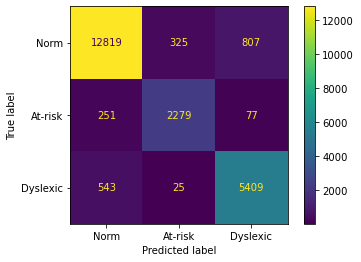

In [41]:
disp = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=class_names
                             )
disp.plot()
plt.show()


In [61]:
sklearn.metrics.roc_auc_score(y_true=res["3"]["y_test"], 
                              y_score=res["3"]["y_pred_prob"], 
                              multi_class="ovr", 
                              average='weighted'
                             )

0.9823166765651608

In [65]:
sklearn.metrics.roc_auc_score(y_true=res["3"]["y_test"], 
                              y_score=res["3"]["y_pred_prob"], 
                              multi_class="ovr",
                              average='macro'
                             )

0.9860776929771702

In [67]:
sklearn.metrics.roc_auc_score(y_true=res["3"]["y_test"], 
                              y_score=res["3"]["y_pred_prob"], 
                              multi_class="ovo",
                              average='weighted'
                             )

0.9855739294824836

In [68]:
sklearn.metrics.roc_auc_score(y_true=res["3"]["y_test"], 
                              y_score=res["3"]["y_pred_prob"], 
                              multi_class="ovo",
                              average='macro'
                             )

0.9874523748097692

In [ ]:
np.log(4)

In [ ]:
log-uniform(1e-1, 4.0)